# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [4]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
from sklearn.neighbors import KNeighborsRegressor as KNN
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split as sk_split
from sklearn import preprocessing
import sklearn.discriminant_analysis as da
from random import shuffle
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Zhang, Christine]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

In [2]:
# import ratings and examine dataframe
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [3]:
# import movie names and examine dataframe
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


In [4]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

In [5]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

The goodness of a movie can be modeled by the probability that a user will enjoying watching. This returns a value between 0 and 1 and can be calculated as the number of likes divided by the total number of ratings. A theta_movie of 1 will maximize the likelihood that the user will enjoy the movie. 

Using theta_movie is more appropriate because some movies may have more likes because they are more popular. We want a system that allows us to compare popular and indie movies. A mainstream movie may have 50 likes and 50 dislikes. This would rate it higher than an indie film with 30 likes and no dislikes. Thus, using percentages allows us remove movie popularity as a confunding variable. However, this may be suboptimal in that indie films may have an unfair bias. A classic film may have 99 likes and 1 dislike, which is an extremely high rating. However, it will be rated as lower than a movie with 2 likes and no dislikes. Thus, we need a weighted average that factors in size as well as like percentile.

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

In [7]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

In [8]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [9]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

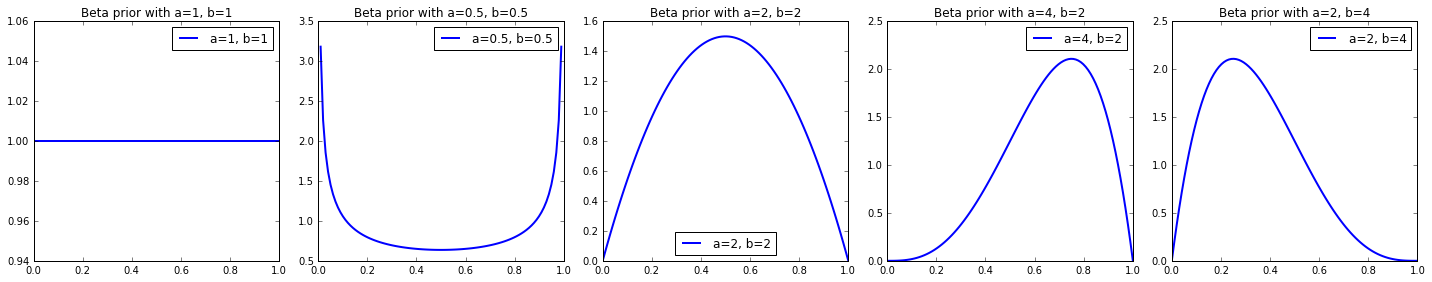

In [10]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

In [11]:
def plot_beta(name):
    #Get the name of the first movie in the top 25 list
    movie_name = name

    #Get the ratings info for the first movie in the top 25 list
    total_ratings, likes = movie_stats(movie_name_contains= name)
    likability = likes/total_ratings

    #Print movie info
    print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

    #Number of samples to use when approximating our posterior
    n_samples = 10000

    #Plot the posterior corresponding to each prior
    fig, ax = plt.subplots(1, n, figsize=(20, 4))

    #Start the index of the current subplot at 0
    ax_ind = 0

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')

        #Set title, legends etc
        ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[ax_ind].legend(loc='best')
        #Increment the subplot index
        ax_ind += 1

    plt.tight_layout()
    plt.show() 

Toy Story: 0.745098039216 (38.0/51.0)


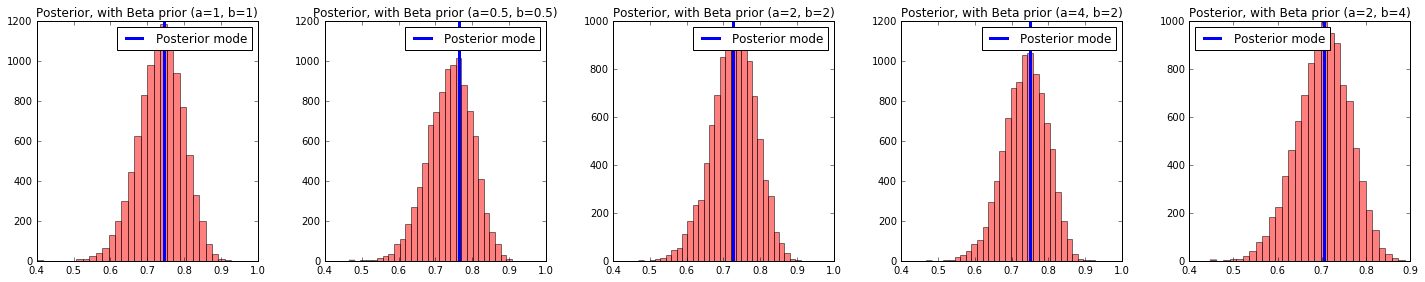

In [12]:
plot_beta("Toy Story")

Star Wars: 0.865671641791 (58.0/67.0)


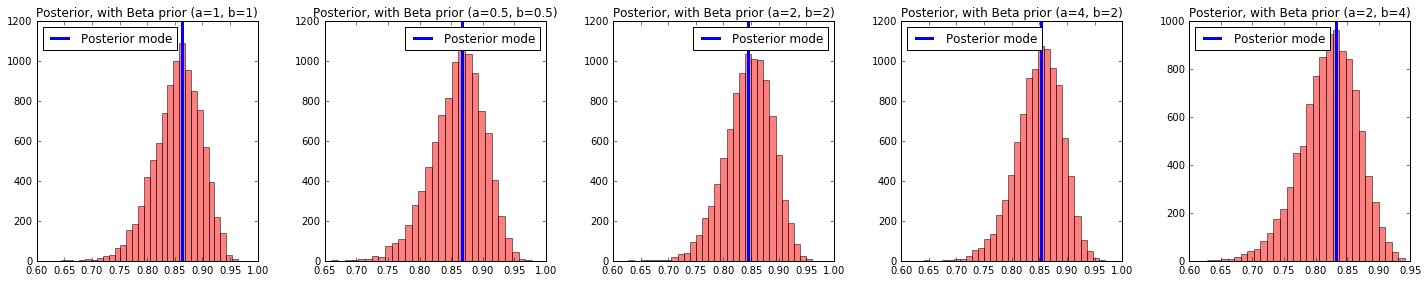

In [13]:
plot_beta("Star Wars")

Shawshank Redemption: 1.0 (39.0/39.0)


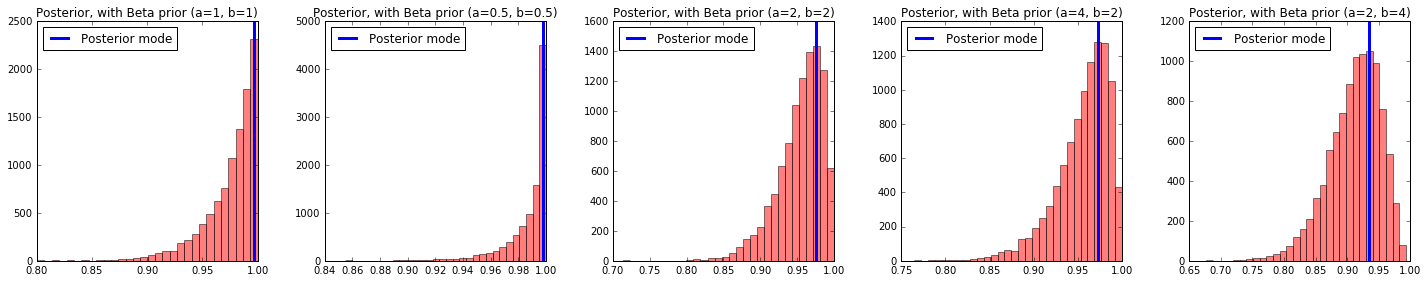

In [14]:
plot_beta("Shawshank Redemption")

Down Periscope: 0.0666666666667 (1.0/15.0)


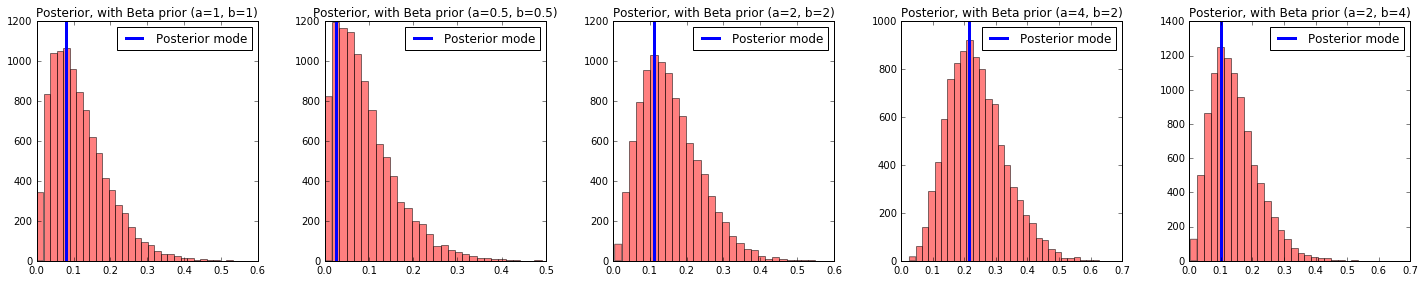

In [15]:
plot_beta("Down Periscope")

Chain Reaction: 0.0 (0.0/10.0)


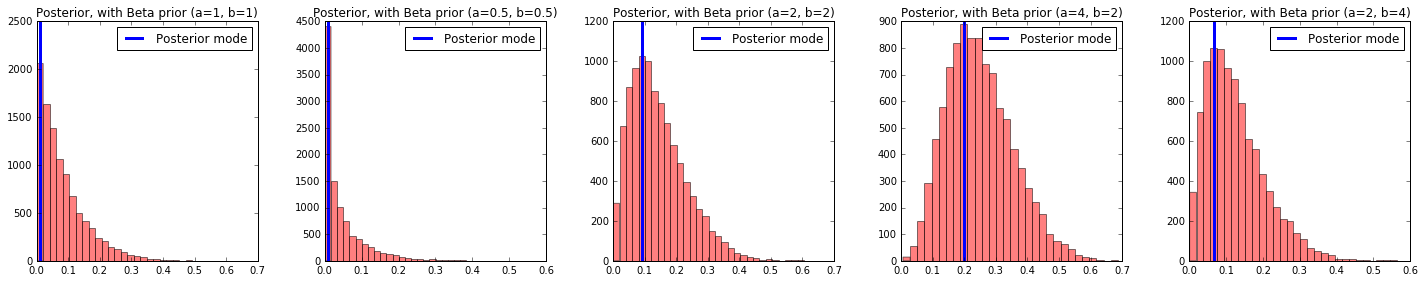

In [16]:
plot_beta("Chain Reaction")

In [45]:
# redefine movie_stats to take in new parameter size
def movie_stats(size = None, movie_name = None, movie_name_contains=None):
    
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
        
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get a specified number of movies, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        ratings_for_movie = ratings_for_movie.as_matrix()
        #Truncate matrix to given size
        ratings_for_movie = ratings_for_movie[:size]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        ratings = []
        for each in ratings_for_movie:
            ratings.append(each[2])
        ratings = np.array(ratings)
        likes = ratings.sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

In [40]:
def plot_beta_size(size):
    
    total_ratings, likes = movie_stats(size, movie_name_contains= movie_name)
    likability = likes/total_ratings
   
    #Print movie info
    print 'Number of samples: ', size
    print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

    #Number of samples to use when approximating our posterior
    n_samples = 10000

    #Plot the posterior corresponding to each prior
    fig, ax = plt.subplots(1, n, figsize=(20, 4))

    #Start the index of the current subplot at 0
    ax_ind = 0

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')

        #Set title, legends etc
        ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[ax_ind].legend(loc='best')
        #Increment the subplot index
        ax_ind += 1

    plt.tight_layout()
    plt.show() 

Number of samples:  5
Star Wars: 1.0 (5.0/5.0)


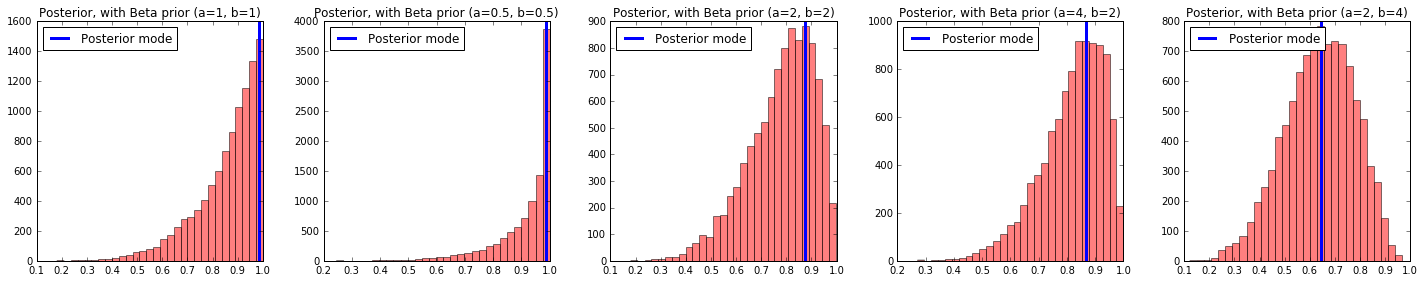

Number of samples:  10
Star Wars: 0.9 (9.0/10.0)


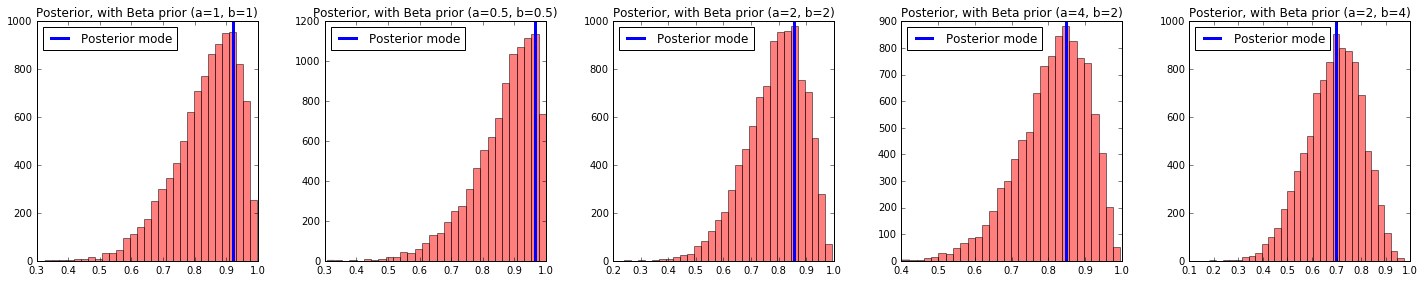

Number of samples:  20
Star Wars: 0.9 (18.0/20.0)


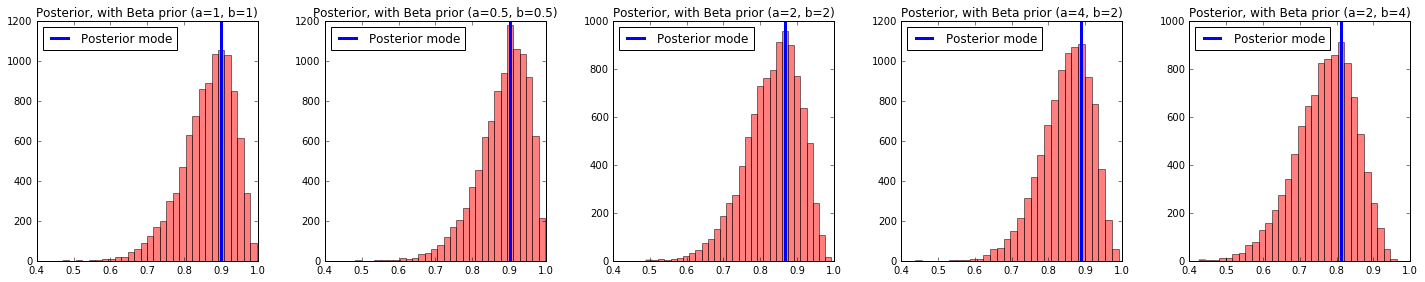

Number of samples:  67
Star Wars: 0.865671641791 (58.0/67.0)


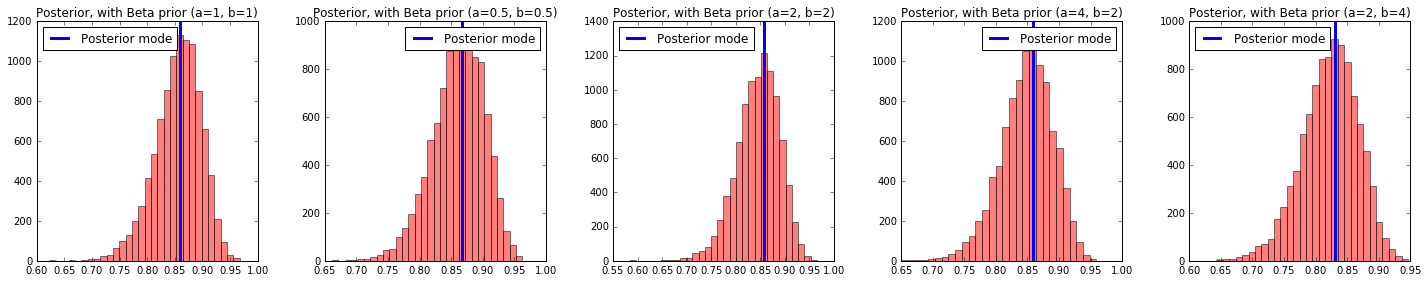

In [41]:
#Get the name of the first movie in the top 25 list
movie_name = "Star Wars"

#Get the ratings info for the first movie in the top 25 list
plot_beta_size(5)
plot_beta_size(10)
plot_beta_size(20)
plot_beta_size(67)

Beta distributions are appropriate priors because they allow us to update our probabilities based on what we expect the distribution to look like. This is due to the statistical relationship of the beta and binomial distributions, known as the beta-binomial conjugacy. For example, a beta of a = b = 2 shows a bell curve distribution so if we believe that most movie ratings tend to fall near the middle, we can update our movie likelihood probabilities accordingly. 

The betas change based on the extreme ratings and on sample size. Looking at Toy Story, since there were many ratings and the average likeability was in the mid-upper range, changing the betas did not have as prominent as an effect. In contrast, there was a much larger difference for Chain Reaction since the average score was very small and close to zero. Especially depending on our beta values, this would produce wildly different posterior values. 

Sample size also plays a large role as increasing sample size tended to stabilize the posterior modes across different values of beta. For Star Wars, with all samples included, the posterior modes were much more consistent than they were for a sample size for five. With a sample size of 5, the posterior mode was much higher for a = b = 1 than for a = 2 and b = 4. This shows that sample size has a major influence since it lends credibility to a good rating. If a movie consistently scores high, then it is not by chance. There is a greater chance that the movie is objectively a classic.

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

In [47]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name = name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.996978896924 (39.0/39.0)
Three Colors: Red (1994) : 0.950438427528 (12.0/12.0)
Schindler's List (1993) : 0.935616588736 (29.0/34.0)
High Noon (1952) : 0.93533473636 (11.0/11.0)
Alien (1979) : 0.92410130332 (28.0/30.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 0.913948220625 (6.0/6.0)
Cool Hand Luke (1967) : 0.911362911084 (20.0/20.0)
Taxi Driver (1976) : 0.907498329078 (17.0/18.0)
Third Man, The (1949) : 0.906225272355 (9.0/9.0)
Babe (1995) : 0.904353546852 (24.0/27.0)
Paths of Glory (1957) : 0.903950153808 (4.0/4.0)
Usual Suspects, The (1995) : 0.902433451955 (27.0/29.0)
Searching for Bobby Fischer (1993) : 0.901663067043 (17.0/19.0)
Vertigo (1958) : 0.901162743845 (22.0/23.0)
Godfather: Part II, The (1974) : 0.898930495864 (18.0/18.0)
Silence of the Lambs, The (1991) : 0.897709059338 (42.0/47.0)
Priest (1994) : 0.892036969836 (5.0/6.0)
Exotica (1994) : 0.890753934402 (2.0/2.0)
Sling Blade (

The new list of top 25 movies is much more accurate and consistent with classic, highly regarded movies. This method of ranking is better because it factors in both the number of likes and the percentage of likes over the total number of ratings with the priors. I took a = b = 2 because I assumed that most movie ratings would fall near the center. Thus, if a movie has a high rating with many ratings, it suggests that it is a classic because it consistently performs above average. 

The draw back of this method is that there may be a subset of users with likes more similiar to yours instead of comparing against the general population. We can improve this system by comparing how viewers with past similiar preferences rated movies instead of using all user input. This allows us to custom tailor the rating system to more accurate predict your individual tastes. For example, if a user enjoyed movie X, then there exists a higher rate of enjoying movie Y if there is a correlation between liking X and Y. 

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

In [6]:
# create column names and read in database
column_names = ["lat", "long", "status"]
houses_2000 = pd.read_csv('datasets/dataset_1_year_2000.txt', delimiter = ' ', names = column_names)

# isolate predictors from response variable
x_2000 = houses_2000[['lat','long']]
y_2000 = houses_2000['status']
houses_2000.head()

,lat,long,status
0,0.544328,0.624510,2.0
1,0.594685,0.723913,2.0
2,0.700180,0.782492,2.0
3,0.601262,0.971812,2.0
4,0.631995,0.748502,2.0


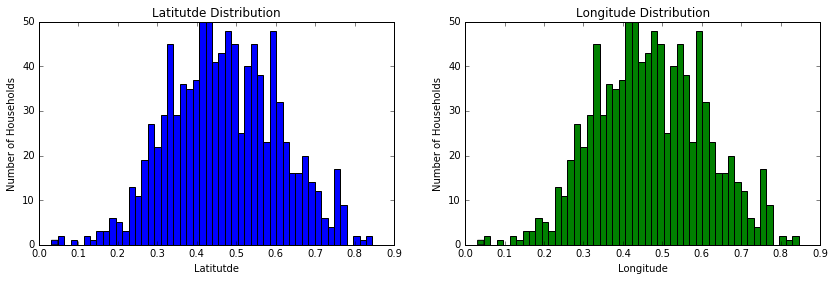

In [7]:
# initialize two figures
fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(14, 4))

# plot latitude ditribution
lat = x_2000['lat']
ax1.hist(lat, bins = 50)
ax1.set_xlabel('Latitutde')
ax1.set_ylabel('Number of Households')
ax1.set_title('Latitutde Distribution')

# plot longitude distribution
long = x_2000['long']
ax2.hist(lat, bins = 50, color = 'g')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Number of Households')
ax2.set_title('Longitude Distribution')

plt.show()

LDA is a better model when the data points are normally distributed. For our housing datasets, LDA is a good fit because both longitude and latitude roughly follow a Gaussian distribution, as indicated by the above histograms. Otherwise, logistic regression is preferred since it uses a maximum likelihood estimation rather than least squares estimation of LDA. This makes LDA highly sensitive to outliers. Thus, based on preliminary analysis, we would predict LDA to be a better model than logistic regression.

In [8]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(comb, model, poly_flag, title, ax):
    # Plot data
    zeros = comb[(comb['status'] == 0.0)]
    ones = comb[(comb['status'] == 1.0)]
    twos = comb[(comb['status'] == 2.0)]
    ax.scatter(zeros.iloc[:, 0], zeros.iloc[:, 1], c='g', label = 'Low Income')
    ax.scatter(ones.iloc[:, 0], ones.iloc[:, 1], c='b', label = 'Middle Class')
    ax.scatter(twos.iloc[:, 0], twos.iloc[:, 1], c='r', label = 'High Income')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [9]:
# initialize logistic regression and LDA models
logreg = sk.linear_model.LogisticRegression(C = 1000000)
lda = da.LinearDiscriminantAnalysis()
lda_score, logreg_score = [], []

In [10]:
def house_info(house_data):
    # separate predictors from response variables
    x_values = house_data[['lat','long']]
    y_values = house_data['status']
    
    # fit datasets to either LDA or logistic regression models
    lda.fit(x_values, y_values)
    logreg.fit(x_values, y_values)
    
    # initialize subplots for visualiziation
    fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(14, 4))
    ax1 = plot_decision_boundary(house_data, lda, False, "Prices LDA", ax1)
    ax2 = plot_decision_boundary(house_data, logreg, False, "Prices LogReg", ax2)
    plt.show()
    
    # calculate accuracy score from both models
    lda_score.append(lda.score(x_values, y_values))
    logreg_score.append(logreg.score(x_values, y_values))
    print 'LDA Misclassification Rate: ', (1 - lda.score(x_values, y_values))
    print 'Logistic Regression Misclassification Rate: ', (1 - logreg.score(x_values, y_values))

In [11]:
# upload all of the dataframes across multiple years
houses_2001 = pd.read_csv('datasets/dataset_1_year_2001.txt', delimiter = ' ', names = column_names)
houses_2002 = pd.read_csv('datasets/dataset_1_year_2002.txt', delimiter = ' ', names = column_names)
houses_2003 = pd.read_csv('datasets/dataset_1_year_2003.txt', delimiter = ' ', names = column_names)
houses_2004 = pd.read_csv('datasets/dataset_1_year_2004.txt', delimiter = ' ', names = column_names)
houses_2005 = pd.read_csv('datasets/dataset_1_year_2005.txt', delimiter = ' ', names = column_names)
houses_2006 = pd.read_csv('datasets/dataset_1_year_2006.txt', delimiter = ' ', names = column_names)
houses_2007 = pd.read_csv('datasets/dataset_1_year_2007.txt', delimiter = ' ', names = column_names)
houses_2008 = pd.read_csv('datasets/dataset_1_year_2008.txt', delimiter = ' ', names = column_names)
houses_2009 = pd.read_csv('datasets/dataset_1_year_2009.txt', delimiter = ' ', names = column_names)
houses_2010 = pd.read_csv('datasets/dataset_1_year_2010.txt', delimiter = ' ', names = column_names)

In [12]:
# turn all the dataframes into an array for looping
houses_array = [(houses_2000, 2000), (houses_2001, 2001), (houses_2002, 2002), (houses_2003, 2003), (houses_2004, 2004), (houses_2005, 2005), (houses_2006, 2006), (houses_2007, 2007), (houses_2008, 2008), (houses_2009, 2009), (houses_2010, 2010)]

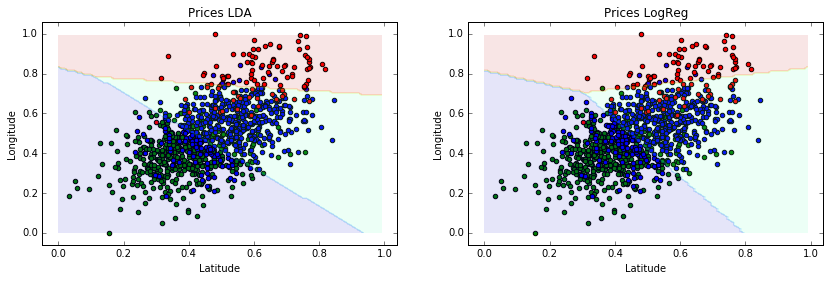

LDA Misclassification Rate:  0.208
Logistic Regression Misclassification Rate:  0.219


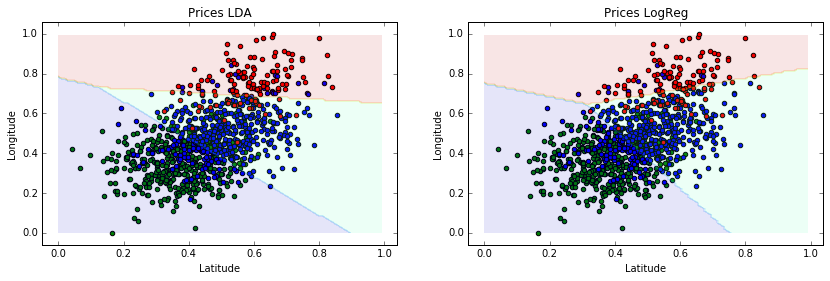

LDA Misclassification Rate:  0.226773226773
Logistic Regression Misclassification Rate:  0.226773226773


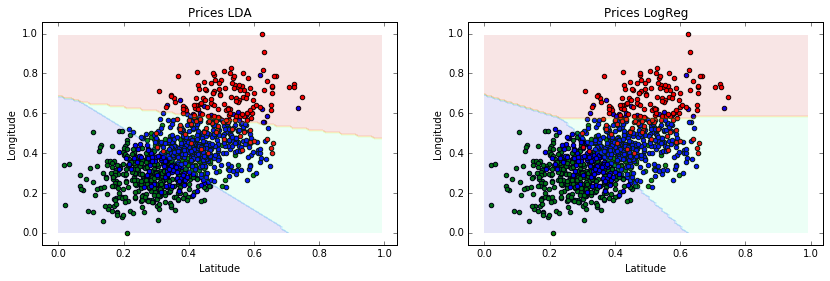

LDA Misclassification Rate:  0.226
Logistic Regression Misclassification Rate:  0.234


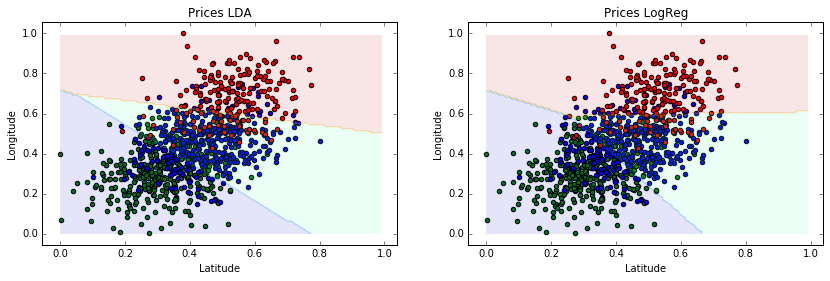

LDA Misclassification Rate:  0.234234234234
Logistic Regression Misclassification Rate:  0.233233233233


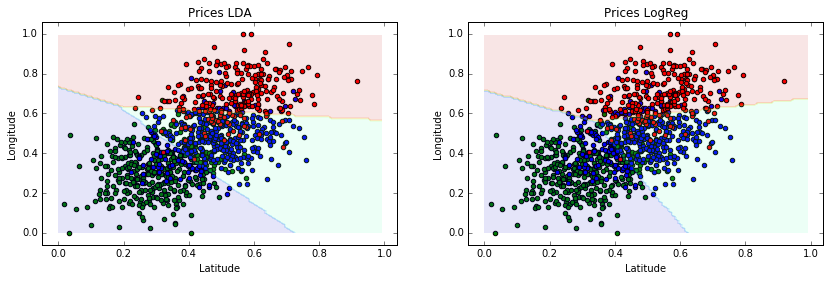

LDA Misclassification Rate:  0.212
Logistic Regression Misclassification Rate:  0.232


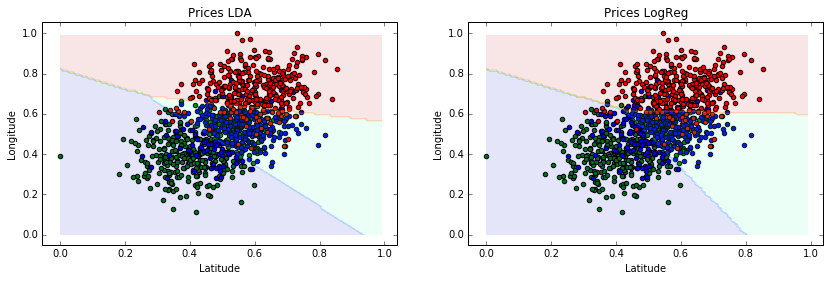

LDA Misclassification Rate:  0.221221221221
Logistic Regression Misclassification Rate:  0.242242242242


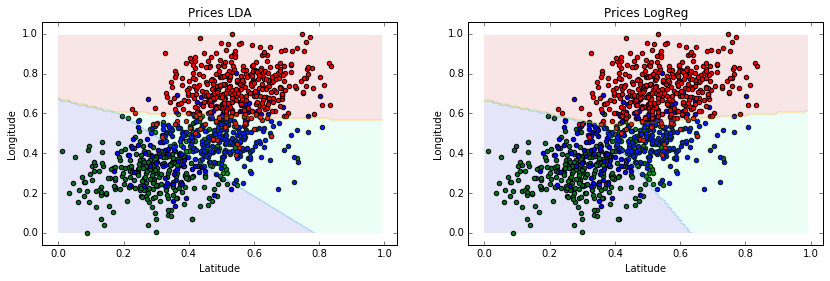

LDA Misclassification Rate:  0.204204204204
Logistic Regression Misclassification Rate:  0.217217217217


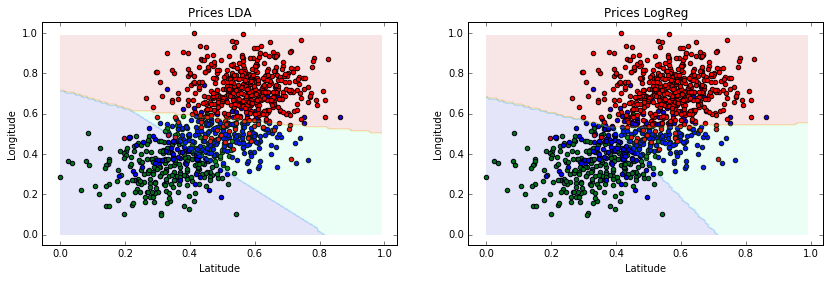

LDA Misclassification Rate:  0.176823176823
Logistic Regression Misclassification Rate:  0.1998001998


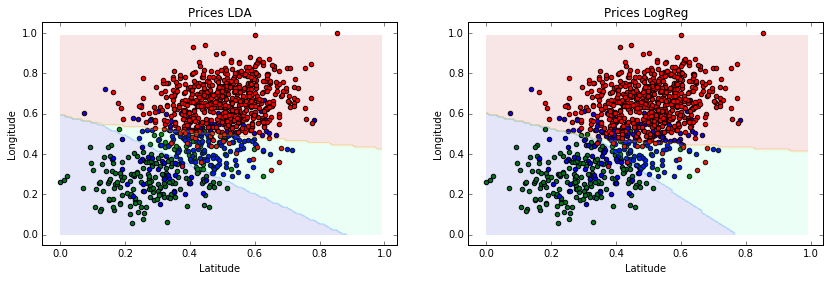

LDA Misclassification Rate:  0.16
Logistic Regression Misclassification Rate:  0.184


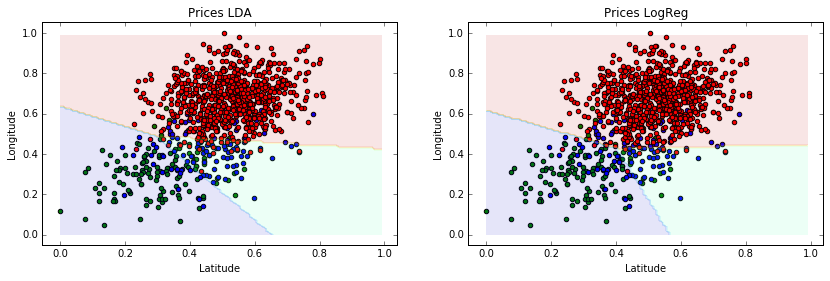

LDA Misclassification Rate:  0.117117117117
Logistic Regression Misclassification Rate:  0.122122122122


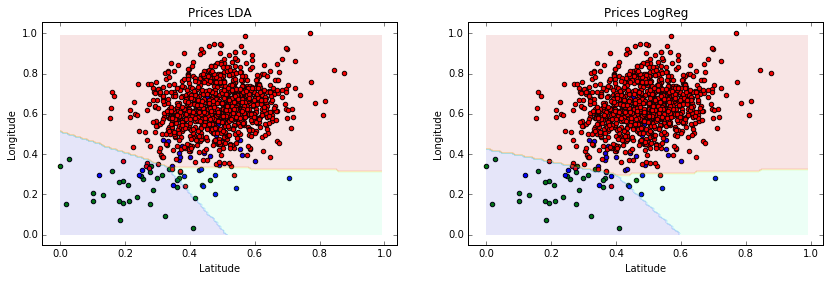

LDA Misclassification Rate:  0.04004004004
Logistic Regression Misclassification Rate:  0.038038038038


In [13]:
# visualize the LDA and Logistic Regression fits for every year
for (house_data, year) in houses_array:
    house_info(house_data)

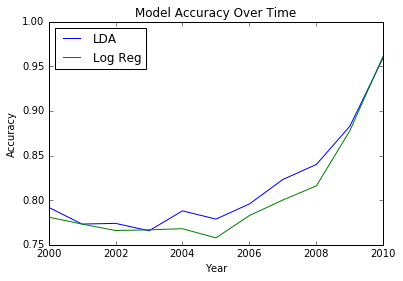

In [14]:
# plot the accuracy of LDA and Logistic regresion over the years
years = range(2000, 2011)
plt.plot(years, lda_score, label = "LDA")
plt.plot(years, logreg_score, label = "Log Reg")

# Add axes labels and title
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Time')
plt.legend(loc = 'best')
plt.show()

From the graph above plotting the accuracy of the LDA model and the logistic regression model over time, we see that the LDA model results in a higher accuracy in classifying neighborhoods. This agrees with our intutition since the latitude and longitude data was approximately noramlly distributed. We can then proceed with LDA as a more accurate model.

In [15]:
accuracy_rates = []
def priors(house_data, year):
    
    #calculate number of years from 2000
    year_dif = year - 2000
    
    #separate predictor from response variables
    x_2000 = houses_2000[['lat','long']]
    y_2000 = houses_2000['status'] 
    x_year = house_data[['lat','long']]
    y_year = house_data['status']
    
    #fit LDA model to the year 2000 dataset
    lda.fit(x_2000, y_2000)
    
    #update priors to represent 25% gentrification rate (1/1.25 = 0.8)
    total_priors = 0.45*0.8**year_dif + 0.45*0.8**year_dif + 0.1*1.25**year_dif
    lda.priors = np.array([0.45*0.8**year_dif/total_priors, 0.45*0.8**year_dif/total_priors, 0.1*1.25**year_dif/total_priors])
    
    #predict new y values from 2000 using priors and concat onto corresponding predictor variables 
    y_predicted_lga = lda.predict(x_year)
    y_predicted_lga = pd.DataFrame({'status':y_predicted_lga})
    combined_lga = pd.concat([x_year, y_predicted_lga], axis=1)
    
    #plot the results to visualize and calculate error rate 
    fig, ax1 = plt.subplots(figsize=(7, 4))
    plot_decision_boundary(combined_lga, lda, False, year, ax1)
    plt.show()
    accuracy = lda.score(x_year, y_year)
    accuracy_rates.append(accuracy)
    print year, 'LDA Misclassification Rate: ', (1 - lda.score(x_year, y_year))

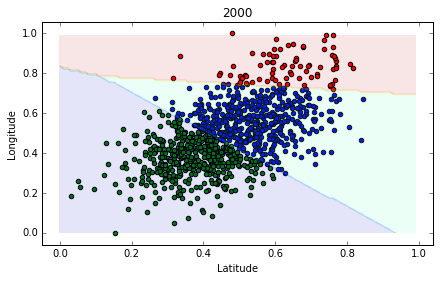

2000 LDA Misclassification Rate:  0.208


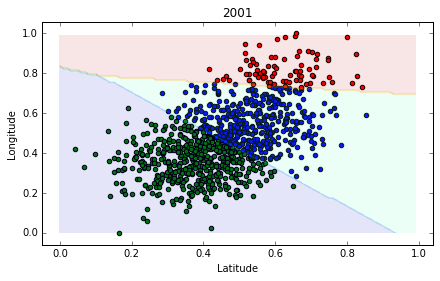

2001 LDA Misclassification Rate:  0.233766233766


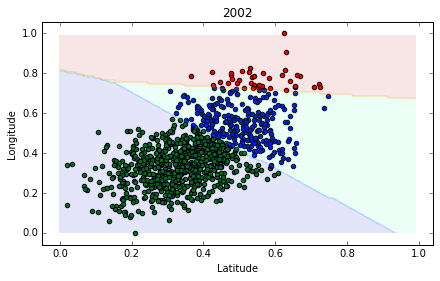

2002 LDA Misclassification Rate:  0.408


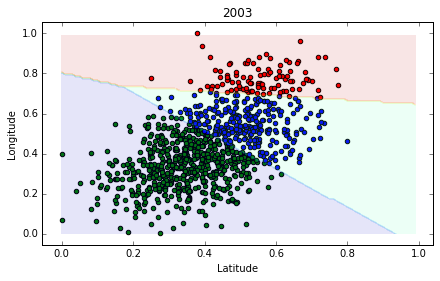

2003 LDA Misclassification Rate:  0.338338338338


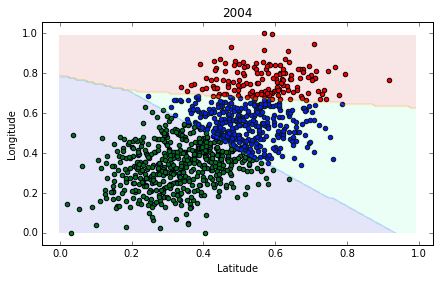

2004 LDA Misclassification Rate:  0.276


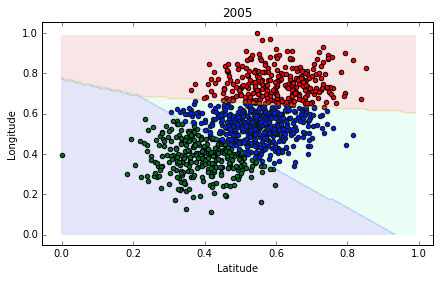

2005 LDA Misclassification Rate:  0.223223223223


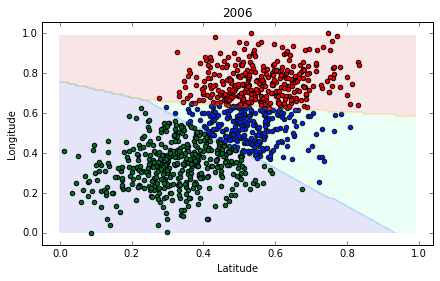

2006 LDA Misclassification Rate:  0.263263263263


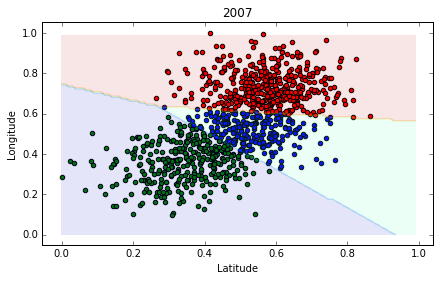

2007 LDA Misclassification Rate:  0.203796203796


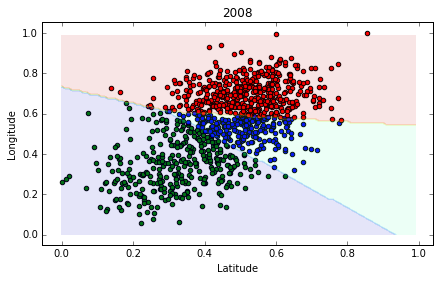

2008 LDA Misclassification Rate:  0.283


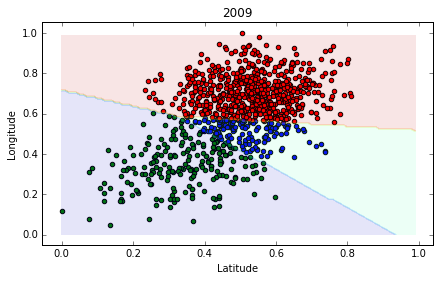

2009 LDA Misclassification Rate:  0.209209209209


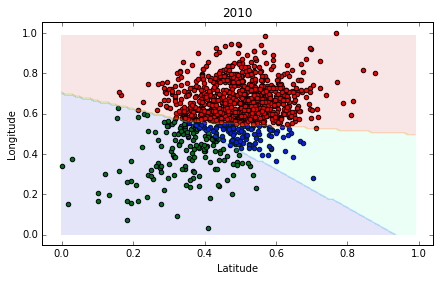

2010 LDA Misclassification Rate:  0.232232232232


In [16]:
for (house_data, year) in houses_array:
    priors(house_data, year)

In [17]:
def classify(lat, longi, year):
    #calculate number of years from 2000
    year_dif = year - 2000
    
    #separate predictors from response variables
    x_2000 = houses_2000[['lat','long']]
    y_2000 = houses_2000['status'] 
    x_test = np.array([lat, longi])
    x_test = x_test.reshape(1,-1)
    
    # fit the LDA model to year 2000 data
    lda.fit(x_2000, y_2000)
    
    #update priors according to gentrification rate of 25%
    total_priors = 0.45*0.8**year_dif + 0.45*0.8**year_dif + 0.1*1.25**year_dif
    lda.priors = np.array([0.45*0.80**year_dif/total_priors, 0.45*0.8**year_dif/total_priors, 0.1*1.25**year_dif/total_priors])
    
    #use LDA to predict classification
    neighborhood = lda.predict(x_test)
    print neighborhood[0]
    
# test year post-2010 to demonstrate flexibility of classifer    
classify(.6, .6, 2013)

2.0


Updating betas to predict classification proves to be a very effective method, almost as accurate as using actual data. I used 2000 predictors and response variables but reassigned the prior values for each year. With each year that passes from 2000, the number of high income neighborhoods increases by $1.25^{n}$ where $n = \text{number of years}$ while the number of middle and low income neighborhoods decreases by $\frac{1}{1.25}^n = 0.8^n$. The resulting classification rates were in line with the results obtained during the data directly. Year 2000 misclassification rate was .208 while year 2010 misclassification rate was 0.2322. Using priors allows us to just rely on 2000 data to predict responses for any year post 2000. 

This poses a tremendous advantage since it allows us to be more computationally effective and extrapolate out further. For starters, we only need one dataset (2000 data) instead of a dataset per each year. Secondly, we can extrapolate out past 2010 whereas, we would not be able to do that with our previous method that relied on solid data. In the example above, I was able to classify 0.6 latitude, 0.6 longitude for year 2013. 

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

In [18]:
# read in datasets and separate reponse variables from predictors
house_1 = pd.read_csv('datasets/dataset_2.txt', delimiter = ' ', names = column_names)
x_1 = house_1[['lat','long']]
y_1 = house_1['status']
house_2 = pd.read_csv('datasets/dataset_3.txt', delimiter = ' ', names = column_names)
x_2 = house_2[['lat','long']]
y_2 = house_2['status']

In [34]:
def score(house_data):
    
    # separate response variables from predictors
    X = house_data[['lat','long']]
    y = house_data['status']
    
    #initialize and fit LDA, QDA, and Logistic Regression models
    lda = da.LinearDiscriminantAnalysis()
    qda = da.QuadraticDiscriminantAnalysis()
    lda.fit(X,y)
    qda.fit(X,y)
    logreg = sk.linear_model.LogisticRegression(C = 1000000)
    logreg2 = sk.linear_model.LogisticRegression(C = 1000000)
    logreg.fit(X,y)
    
    quad_features = preprocessing.PolynomialFeatures(degree=2)
    xx = quad_features.fit_transform(X)
    logreg2.fit(xx, y)
    
    # Initialize and fit KNN on 3 and 25 neighbors
    x_train, x_test, y_train, y_test = sk_split(X, y, test_size = 0.3)
    neighbours_3 = KNN(n_neighbors = 3)
    neighbours_3.fit(x_train, y_train)
    r_KNN_3 = neighbours_3.score(x_test, y_test)
    
    neighbours_25 = KNN(n_neighbors = 25)
    neighbours_25.fit(x_train, y_train)
    r_KNN_25 = neighbours_25.score(x_test, y_test)
    
    # plot the datasets to visualize the boundaries
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(14, 16))
    ax1 = plot_decision_boundary(house_data, lda, False, "LDA", ax1)
    ax2 = plot_decision_boundary(house_data, logreg, False, "LogReg", ax2)
    ax3 = plot_decision_boundary(house_data, qda, False, "QDA", ax3)
    ax4 = plot_decision_boundary(house_data, neighbours_3, False, "KNN = 3", ax4)
    ax5 = plot_decision_boundary(house_data, neighbours_25, False, "KNN = 25", ax5)
    ax6 = plot_decision_boundary(house_data, logreg2, True, "Polynomial LogReg", ax6)
    plt.show()

    # print misclassification rates to determine the best model
    print "Overall misclassification rate of Logistic Regression is",(1-logreg.score(X,y))
    print "Overall misclassification rate of LDA is",(1-lda.score(X,y))
    print "Overall misclassification rate of QDA is",(1-qda.score(X,y))
    print "Overall misclassification rate of kNN3 is",(1-neighbours_3.score(X,y))
    print "Overall misclassification rate of kNN25 is",(1-neighbours_25.score(X,y))
    print "Overall misclassification rate of Polynomial Logistic Regression is",(1-logreg2.score(xx,y))

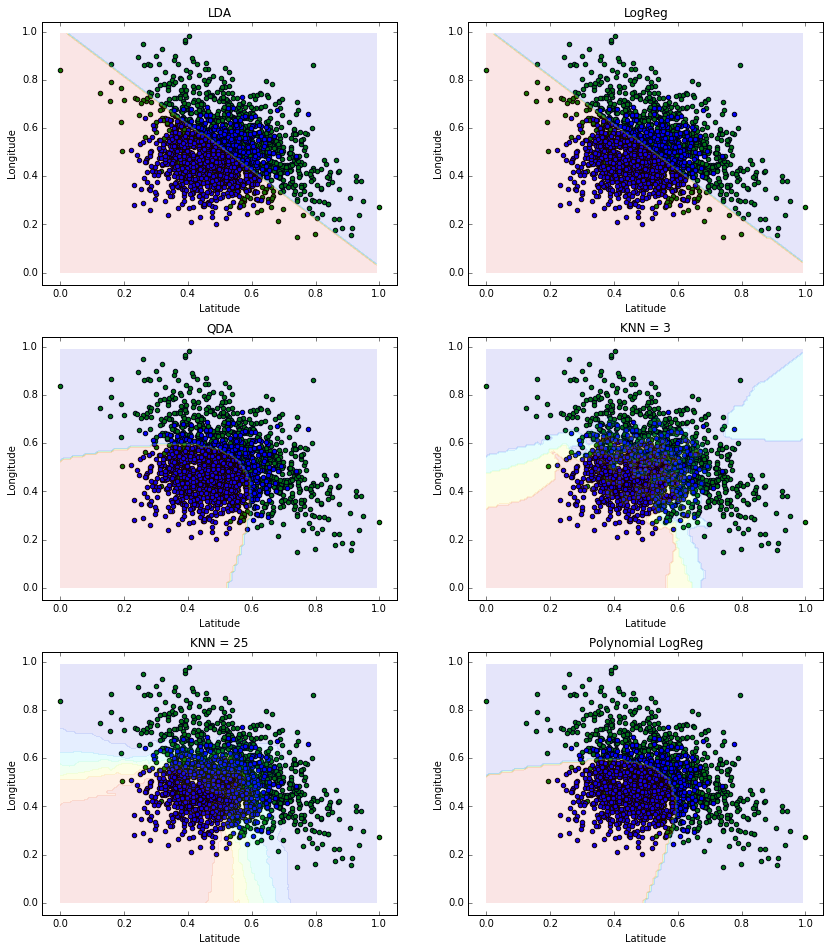

Overall misclassification rate of Logistic Regression is 0.251
Overall misclassification rate of LDA is 0.252
Overall misclassification rate of QDA is 0.2225
Overall misclassification rate of kNN3 is 0.500222222222
Overall misclassification rate of kNN25 is 0.5688512
Overall misclassification rate of Polynomial Logistic Regression is 0.2195


In [35]:
score(house_1)

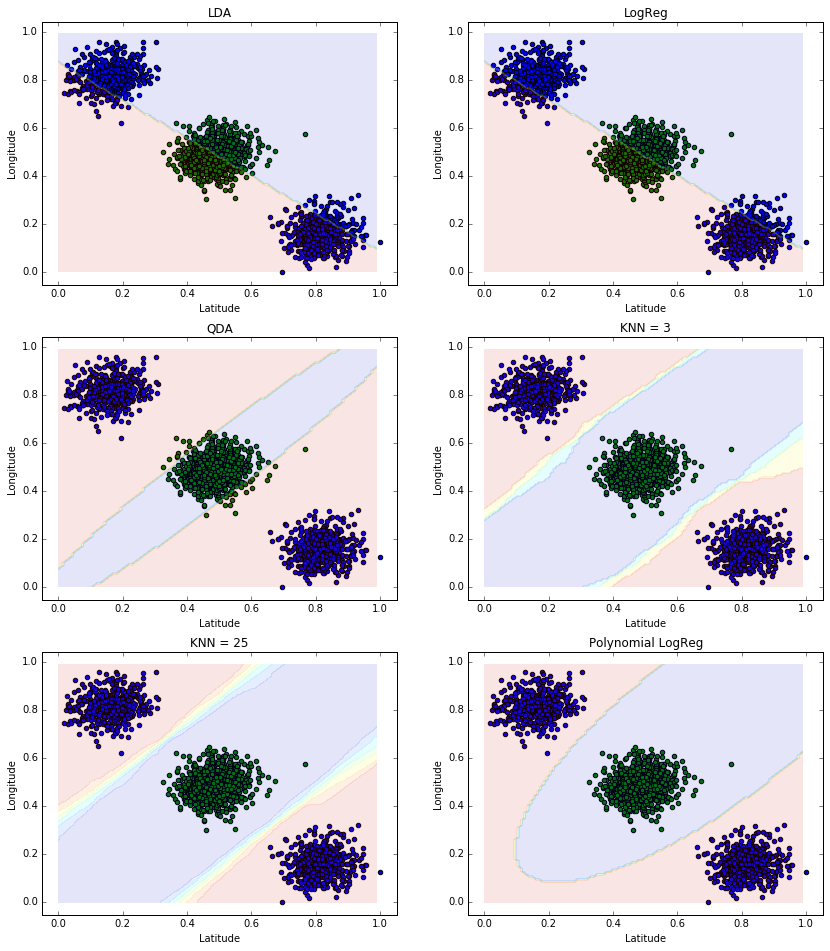

Overall misclassification rate of Logistic Regression is 0.495
Overall misclassification rate of LDA is 0.495
Overall misclassification rate of QDA is 0.017
Overall misclassification rate of kNN3 is 0.0
Overall misclassification rate of kNN25 is 0.0
Overall misclassification rate of Polynomial Logistic Regression is 0.0


In [36]:
score(house_2)

In this problem, I tested six different models. LDA is a binary classifier that is effective for normally distributed predictor values. It separates datapoints with a linear border, maximizing classification accuracy based on the maximum likelihood estimation. Logistic regression is very simliar to LDA but does not assume that parameters follow a Gaussian distribution. Thus, logisitic regression is more applicable for a variety of datasets. Quadratic discriminant analysis is similiar to LDA but instead of a linear boundary, QDA uses a quadratic curved boundary. It is important to note that QDA does not apply to all polynomial curved boundaries but only to quadratic fits ($x^2$). The last fit was KNN, which classify values by taking the average of the nearest k neighbors. KNN was tested with k = 3 and k = 25, which corresponds to nearest 3 and nearest 25 neighborhoods respectively. K = 3 would be better for more localized trends while k = 25 would be more larger, data-set wide trends. Lastly, I tested logistic regression with polynomial fit. This tests improves on logistic regression with curved boundaries. 

For dataset 2, the polynomial logistic regression approach was the most accurate in classifying neighborhoods with a misclassification rate of 0.2195. This is because the neighborhood borders followed a parabolic relationship in classification as there was a curved line separating 1 from 0. This was more accurate than both LDA and logistic regression, which relied on a linear border and misclassified points in the middle. Since there was tremendous overlap in the dataset, KNN was not an effective measure since it was easily confused by the 0 and 1 neighborhood classifications. Furthermore, this was slightly more accurate than QDA, which assumes normally distributed values, which wasn't the case with our green points. Even though QDA and Poly logistic regression had similiar classification rates, Poly Logistic regression had a slight edge because it did not have that limiting assumption. 

For dataset 3, Polynomial logistic regression and KNN tied for the best apporach since the data was clearly separated into clusters of 1 and 0. Thus, choosing the closest neighbors gave you a highly accurate estimate of classification. KNN with 3 closest neighbors, KNN was 25 closest neighbors, and polynomial logistic regression equally gave us misclassification rates of 0%. This is because the data is so clearly separated that the number of neighbors selected did not make a large impact. LDA and linear logistic regression were poor models since there were three bundles of data, with two bordering a different neighborhood class. This made it difficult to classify the groups with just one line of separation. Furthermore, QDA was a better method than LDA and linear logistic regression but it was hard to separate the middle neighborhood with a parabolic curve. There were a few outlier points that escaped the equation and ended up being misclassified. Thus, while QDA had a low misclassification rate, it was not as low as KNN, with k = 3 or k = 25, or polynomial logistic regression. 

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

Be detailed in your explanation and support your reasoning fully. You do not, however, need to implement any of these solutions.